In [1]:
%matplotlib inline
import os
import glob
import time
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

import openmc.data
import vectfit as m

/home/software/nse/miniconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Nuclide

In [2]:
nuc_name = 'S33'
endf_file = os.path.join(os.environ['OPENMC_ENDF_DATA'],"neutrons/n-016_S_033.endf")
ace_file = '{}.h5'.format(nuc_name)
n_poles = 20

## 0K ACE data

In [3]:
# get 0K ACE data
if os.path.isfile(ace_file):
    nuc_ce = openmc.data.IncidentNeutron.from_hdf5(ace_file)
else:
    nuc_ce = openmc.data.IncidentNeutron.from_njoy(endf_file,
                                                   temperatures=[0.0], error=0.0005,
                                                   broadr=False, heatr=False, purr=False)
    nuc_ce.export_to_hdf5(ace_file)

## Parse RRR XS

In [4]:
# RRR bound
endf_res = openmc.data.IncidentNeutron.from_endf(endf_file).resonances
rrr_bound_energy = nuc_ce.energy['0K'][-1];
try:
    rrr = endf_res.resolved
except:
    rrr = None
if rrr is not None and hasattr(rrr, 'energy_max') and \
     type(rrr) is not openmc.data.ResonanceRange:
    # openmc.data.ResonanceRange is the base class which has no resonances
    rrr_bound_energy = rrr.energy_max
else:
    # no resolved resonance parameters
    print("WARNING: no RRR data in ENDF.")
    try:
        # set rrr bound as min of unresolved
        rrr_bound_energy = endf_res.unresolved.energy_min
    except:
        print("WARNING: no URR data in ENDF.")

rrr_bound_idx = np.searchsorted(nuc_ce.energy['0K'], rrr_bound_energy,
                                side='right') - 1

print("RRR bound energy: {:.2e} eV (idx={})".format(nuc_ce.energy['0K'][rrr_bound_idx],rrr_bound_idx))

# first threshold
first_threshold_idx = float("inf")
first_threshold_mt = None
for mt in nuc_ce.reactions:
    threshold_idx = nuc_ce.reactions[mt].xs['0K']._threshold_idx
    if threshold_idx > 0 and threshold_idx < first_threshold_idx:
        first_threshold_idx = threshold_idx
        first_threshold_mt = mt

if first_threshold_idx < float("inf"):
    print("First threshold: mt={}, energy={:.2e} eV (idx={})".format(
        first_threshold_mt, nuc_ce.energy['0K'][first_threshold_idx], first_threshold_idx))

# lower of RRR bound and first threshold
e_max_idx = min(rrr_bound_idx, first_threshold_idx)

print("Energy range to be fitted: {:.2e} to {:.2e} eV ({} points)".format(
      nuc_ce.energy['0K'][0], nuc_ce.energy['0K'][e_max_idx], e_max_idx+1))

RRR bound energy: 2.60e+05 eV (idx=4142)
First threshold: mt=51, energy=8.66e+05 eV (idx=4168)
Energy range to be fitted: 1.00e-05 to 2.60e+05 eV (4143 points)


In [5]:
# parse energy & xs
energy = nuc_ce.energy['0K'][:e_max_idx+1]

total_xs = nuc_ce[1].xs['0K'](energy)

if 2 in nuc_ce:
    elastic_xs = nuc_ce[2].xs['0K'](energy)
else:
    print("WARNING: no elastic scattering xs")
    elastic_xs = np.zeros_like(total_xs)
    
if 27 in nuc_ce:
    absorption_xs = nuc_ce[27].xs['0K'](energy)
else:
    print("WARNING: no absorption xs")
    absorption_xs = np.zeros_like(total_xs)

fissinable = False
if 18 in nuc_ce:
    fission_xs = nuc_ce[18].xs['0K'](energy)
    fissinable = True

atomic_weight_ratio = nuc_ce.atomic_weight_ratio

## Vector Fitting

In [6]:
# make vectors to be fitted
if fissinable:
    ce_xs = np.vstack((elastic_xs, absorption_xs, fission_xs))
else:
    ce_xs = np.vstack((elastic_xs, absorption_xs))

Nv = ce_xs.shape[0]
f = ce_xs * energy
s = np.sqrt(energy)
weight = 1.0/f

In [7]:
# test data: interpolate xs with finer grids
Ne = len(energy)
N_finer = 10
Ne_test = (Ne-1)*N_finer + 1
test_energy = np.interp(np.arange(0, Ne_test, 1), np.arange(0, Ne_test, N_finer), energy)
test_energy[0] = energy[0]
test_energy[-1] = energy[-1]
test_s = np.sqrt(test_energy)
test_xs_ref = np.zeros((Nv, Ne_test))
for i in range(Nv):
    test_xs_ref[i] = np.interp(test_energy, energy, ce_xs[i])
total_xs_ref = np.interp(test_energy, energy, total_xs)

In [8]:
# guess poles
N = n_poles
poles = np.linspace(s[0], s[-1], N//2);
poles = poles + poles*0.01j
poles = np.sort(np.append(poles, np.conj(poles)))

In [9]:
# fitting iterations
for i in range(20):
    print("Iter {}".format(i+1))
    poles, residues, cf, f_fit, rms = m.vectfit(f, s, poles, weight)
    # calculate xs using fitting poles and residues
    test_xs = m.evaluate(test_s, poles, residues, cf)/test_energy
    total_xs_test = test_xs[0]+test_xs[1]
    abserr = np.abs(test_xs - test_xs_ref)
    relerr = abserr/test_xs_ref
    maxrelerr = np.max(relerr[abserr > 1E-5])
    satisfaction = ((relerr < 0.001) | (abserr < 1E-5)).sum()/np.size(relerr)
    print("Max Relative Error:{:.3f}%,  Satisfaction:{:.1f}%".format(maxrelerr*100, satisfaction*100))
    if satisfaction >= 1.0:
        print("Found ideal results. Stop!")
        break

Iter 1
Max Relative Error:1344.371%,  Satisfaction:7.1%
Iter 2
Max Relative Error:3.217%,  Satisfaction:82.2%
Iter 3
Max Relative Error:0.054%,  Satisfaction:100.0%
Found ideal results. Stop!


In [10]:
poles

array([-1175.52980067+0.00000000e+00j,   750.18646812+1.26498369e+03j,
         750.18646812-1.26498369e+03j,  1081.57231511+0.00000000e+00j,
           3.08371226+7.61467695e+01j,     3.08371226-7.61467695e+01j,
         470.10590208+6.59804747e-01j,   470.10590208-6.59804747e-01j,
         357.07114016+4.48559759e-01j,   357.07114016-4.48559759e-01j,
         115.97413051+3.59564083e-02j,   115.97413051-3.59564083e-02j,
         154.69321802+8.72847373e-02j,   154.69321802-8.72847373e-02j,
         278.74700207+3.41418361e-01j,   278.74700207-3.41418361e-01j,
         231.30046967+3.00457974e-01j,   231.30046967-3.00457974e-01j,
         228.03491454+2.81407197e-01j,   228.03491454-2.81407197e-01j])

## Plot

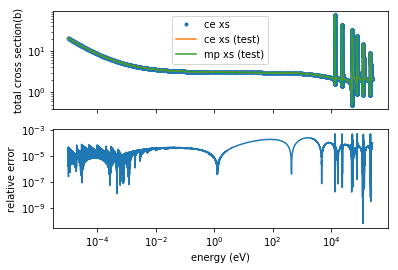

In [11]:
ax1 = plt.subplot(211)
ax1.loglog(energy, total_xs, '.', label="ce xs")
ax1.loglog(test_energy, total_xs_ref, label="ce xs (test)")
ax1.loglog(test_energy, total_xs_test, label="mp xs (test)")
ax1.set_ylabel("total cross section(b)")
ax1.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(212)
ax2.loglog(test_energy, np.abs(total_xs_ref - total_xs_test)/total_xs_ref)
ax2.set_xlabel('energy (eV)')
ax2.set_ylabel('relative error')
plt.show()